In [1]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

### Read the data

Note about the data: The dataset is rather large, and very skewed toward valid transactions. To balance it a bit better, we sample and only keep around 5% of the valid transactions

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14987 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[-1.30935976e-01  1.18590069e-01 -2.27898637e-01  1.43754989e-01
 -8.40391596e-02 -4.11203755e-02 -1.80095560e-01  2.90122110e-02
 -8.48341442e-02 -1.80792781e-01  1.16248322e-01 -1.93028312e-01
 -1.21977554e-02 -2.15601424e-01 -3.67546134e-03 -1.27643149e-01
 -2.03370165e-01 -6.96279400e-02  1.31197147e-02  9.79558169e-03
  1.57893112e-02  4.12297868e-03 -4.53991555e-03 -9.26844808e-03
  3.63303940e-03  2.88372901e-03  7.25476920e-03  5.36939983e-03
  8.65322987e+01]
[5.81422266e+00 3.53893634e+00 5.22815921e+00 2.75932610e+00
 2.99819153e+00 1.83731886e+00 3.91572881e+00 2.72613856e+00
 1.53972757e+00 2.85541253e+00 1.66448352e+00 2.81317897e+00
 9.96798873e-01 2.91861745e+00 8.52508745e-01 1.71793044e+00
 3.55123593e+00 1.10269812e+00 7.02269898e-01 6.00834679e-01
 9.70866692e-01 5.68914456e-01 4.62628746e-01 3.63621957e-01
 2.86246268e-01 2.32051644e-01 1.99043866e-01 1.24127675e-01
 5.05943367e+04]
The PCA features have mean 0 but different variances
The transaction amount is not 

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[ 3.88442864e-16  2.15081172e-16 -1.81456682e-17 -3.38356153e-16
  2.33030531e-16 -4.18546746e-18  9.87214729e-17 -2.56335807e-16
 -2.19097184e-16  1.29962098e-15 -1.07497991e-16 -3.43971347e-16
  2.20525984e-16  5.92168641e-16  6.47658495e-16  1.64922234e-16
  8.39908498e-17  3.92604256e-16 -2.34089862e-18 -1.08585101e-16
 -6.75712239e-17 -1.42913342e-16 -1.72819063e-16 -3.78497749e-17
 -8.33974764e-16  4.83106656e-17  1.47692831e-16 -2.01402472e-17
  8.58712358e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


### Preliminary plotting

[ 1.06937359  1.32270727 -0.24604595  1.15431212 -0.71476402  0.92706025
 -0.54962614 -0.42607169 -1.16572175]


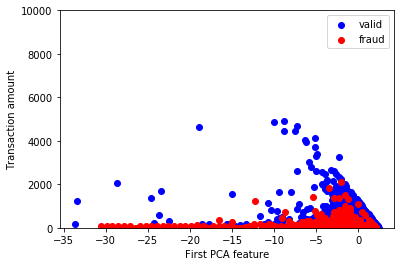

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False negatives (valid):', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False positives (fraud):', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    fscore = 2*confusion_mat[1,1] / (2*confusion_mat[1,1] + confusion_mat[0,1] + confusion_mat[1,0])
    print('F-score: {}'.format(fscore))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0
[[2894    5]
 [  20   79]]
Fold 1
[[2889   10]
 [  18   81]]
Fold 2
[[2888   11]
 [  28   70]]
Fold 3
[[2888   11]
 [  19   79]]
Fold 4
[[2889   10]
 [  16   82]]
Final Confusion Matrix
[[2889.6    9.4]
 [  20.2   78.2]]
False negatives (valid): 0.0032424974129010003
False positives (fraud): 0.20528455284552843
F-score: 0.8408602150537635


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data, scale=True);

Fold 0
[[2899    0]
 [  16   83]]
Fold 1
[[2899    0]
 [  16   83]]
Fold 2
[[2898    1]
 [  29   69]]
Fold 3
[[2899    0]
 [  19   79]]
Fold 4
[[2897    2]
 [  18   80]]
Final Confusion Matrix
[[2.8984e+03 6.0000e-01]
 [1.9600e+01 7.8800e+01]]
False negatives (valid): 0.00020696791997240426
False positives (fraud): 0.1991869918699187
F-score: 0.8863892013498313


#### Linear SVM with Scaling and Class Weights

In [10]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[2824   75]
 [  10   89]]
Fold 1
[[2814   85]
 [  10   89]]
Fold 2
[[2837   62]
 [  12   86]]
Fold 3
[[2828   71]
 [   5   93]]
Fold 4
[[2809   90]
 [   7   91]]
Final Confusion Matrix
[[2822.4   76.6]
 [   8.8   89.6]]
False negatives (valid): 0.026422904449810276
False positives (fraud): 0.0894308943089431
F-score: 0.6772486772486773


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [11]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[2899    0]
 [  22   77]]
Fold 1
[[2899    0]
 [  22   77]]
Fold 2
[[2898    1]
 [  30   68]]
Fold 3
[[2899    0]
 [  19   79]]
Fold 4
[[2897    2]
 [  15   83]]
Final Confusion Matrix
[[2.8984e+03 6.0000e-01]
 [2.1600e+01 7.6800e+01]]
False negatives (valid): 0.00020696791997240426
False positives (fraud): 0.21951219512195122
F-score: 0.8737201365187713


In [12]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[2890    9]
 [  45   54]]
Fold 1
[[2889   10]
 [  50   49]]
Fold 2
[[2892    7]
 [  50   48]]
Fold 3
[[2889   10]
 [  48   50]]
Fold 4
[[2890    9]
 [  42   56]]
Final Confusion Matrix
[[2890.     9. ]
 [  47.    51.4]]
False negatives (valid): 0.003104518799586064
False positives (fraud): 0.4776422764227642
F-score: 0.6473551637279596


#### Polynomial Kernel with Scaling and Class Weights

In [13]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[2897    2]
 [  16   83]]
Fold 1
[[2896    3]
 [  16   83]]
Fold 2
[[2897    2]
 [  26   72]]
Fold 3
[[2894    5]
 [  16   82]]
Fold 4
[[2895    4]
 [  18   80]]
Final Confusion Matrix
[[2895.8    3.2]
 [  18.4   80. ]]
False negatives (valid): 0.0011038289065194895
False positives (fraud): 0.18699186991869915
F-score: 0.881057268722467


In [14]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[2877   22]
 [  13   86]]
Fold 1
[[2868   31]
 [  15   84]]
Fold 2
[[2884   15]
 [  18   80]]
Fold 3
[[2876   23]
 [  10   88]]
Fold 4
[[2878   21]
 [  16   82]]
Final Confusion Matrix
[[2876.6   22.4]
 [  14.4   84. ]]
False negatives (valid): 0.007726802345636426
False positives (fraud): 0.14634146341463414
F-score: 0.8203125


Interestingly, balanced weights peform worse than only using scaled data. The balanced weights overcompensate too much.
Simply scaling the data works best, with the poly kernel (and pretty well with RBF and linear)

### Logistic Regression

In [20]:
def train_logistic_regression(data, folds, labels, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        #print('Fold', i)
        #print(conf_mat)
        #print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [21]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc, folds, labels, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Final Confusion Matrix
[[2.8984e+03 6.0000e-01]
 [1.8200e+01 8.0200e+01]]
F1 score: 0.8950892857142857
Recall: 0.8150406504065041
Precision: 0.9925742574257427
AUC: 0.979873973275639
Checking class weight None and coefficient 0.016681005372000592
Final Confusion Matrix
[[2.8984e+03 6.0000e-01]
 [1.7400e+01 8.1000e+01]]
F1 score: 0.9
Recall: 0.823170731707317
Precision: 0.9926470588235294
AUC: 0.9802891535114469
Checking class weight None and coefficient 0.027825594022071243
Final Confusion Matrix
[[2.8982e+03 8.0000e-01]
 [1.7200e+01 8.1200e+01]]
F1 score: 0.9002217294900221
Recall: 0.8252032520325203
Precision: 0.9902439024390244
AUC: 0.9806583408761501
Checking class weight None and coefficient 0.046415888336127774
Final Confusion Matrix
[[2.8982e+03 8.0000e-01]
 [1.7200e+01 8.1200e+01]]
F1 score: 0.9002217294900221
Recall: 0.8252032520325203
Precision: 0.9902439024390244
AUC: 0.9809973783067955
Checking class weight None and coefficien

Notice how when using balanced class weights, the metric of precision is thrown off since while there is a small false positive rate, the difference in size of the two distributions cause false positives to be on at least the same order of magnitude as the true positives. We can rectify this by downsampling until the two classes have around equal representation.

In [23]:
#Notice that if we fully downsample the dataset so that valid and fraud are equally represented, we have much more consistent metrics.
#Then we see that the recommended parameters begin to converge.

csv_data2 = [row for row in csv_data if int(row[-1]) == 1 or random.random() < 0.00164/.05]

# Find new splits for resampled data
data2 = np.array([[float(x) for x in row[1:-1]] for row in csv_data2])
times2 = np.array([float(row[0]) for row in csv_data2])
labels2 = np.array([int(row[-1]) for row in csv_data2])

data_sc2 = scaler.fit_transform(data2)

fraud_indices2 = np.where(labels2 == 1)[0]
np.random.shuffle(fraud_indices2)
fraud_splits2 = np.array_split(fraud_indices2, 5)

valid_indices2 = np.where(labels2 == 0)[0]
np.random.shuffle(valid_indices2)
valid_splits2 = np.array_split(valid_indices2, 5)

folds2 = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits2, valid_splits2)]

weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc2, folds2, labels2, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Final Confusion Matrix
[[101.8   0.2]
 [ 19.4  79. ]]
F1 score: 0.8896396396396395
Recall: 0.8028455284552845
Precision: 0.9974747474747474
AUC: 0.9772260419319242
Checking class weight None and coefficient 0.016681005372000592
Final Confusion Matrix
[[101.8   0.2]
 [ 18.2  80.2]]
F1 score: 0.8970917225950783
Recall: 0.8150406504065041
Precision: 0.9975124378109452
AUC: 0.9787446291647971
Checking class weight None and coefficient 0.027825594022071243
Final Confusion Matrix
[[101.6   0.4]
 [ 16.6  81.8]]
F1 score: 0.9058693244739755
Recall: 0.83130081300813
Precision: 0.9951338199513381
AUC: 0.9794028722600151
Checking class weight None and coefficient 0.046415888336127774
Final Confusion Matrix
[[101.4   0.6]
 [ 15.   83.4]]
F1 score: 0.9144736842105262
Recall: 0.8475609756097561
Precision: 0.9928571428571429
AUC: 0.9795809232784023
Checking class weight None and coefficient 0.0774263682681127
Final Confusion Matrix
[[100.8   1.2]
 [ 13.

In these cases, the balanced and None class weights perform around the same as expected. However, we can see that the issue with precision and F1 score is fixed. Thus, we advise caution simply using balanced class weights and just looking at the statistics.

# kNN

In [18]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    AU = 0
    errors = 0
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        err = sum([1 if a != b else 0 for a, b in zip(labels[folds[i]], pred)]) / len(pred)
        errors += err

        confusion_mat += conf_mat

    confusion_mat /= 5
    AU /= 5
    errors /= 5
    return confusion_mat, AU, errors

In [21]:
fscores = []
Ks = [1, 3, 5, 7, 9, 11]
for k in Ks:
    conf, au, errors = train_KNN(data, k)
    print('K = {}, errors = {}'.format(k, errors))
    print('Confusion Matrix:')
    print(conf)
    fnr = conf[0, 1] / sum(conf[0, :])
    fpr = conf[1, 0] / sum(conf[1,:])
    print('False Negative Rate: {:3f}\nFalse Positive Rate: {:3f}'.format(fnr, fpr))
    fscore = 2*conf[1,1] / (2*conf[1,1] + conf[0,1] + conf[1,0])
    print('fscore: {}'.format(fscore))
    fscores.append(fscore)
    print()
    
opt_ind = np.argmax(fscores)
k_opt = Ks[opt_ind]
print('The optimal K is {} with fscore {}'.format(k_opt, fscores[opt_ind]))

K = 1, errors = 0.010879150369688397
Confusion Matrix:
[[2831.8   11.2]
 [  20.8   77.6]]
False Negative Rate: 0.003940
False Positive Rate: 0.211382
fscore: 0.829059829059829

K = 3, errors = 0.008907240076824733
Confusion Matrix:
[[2.8408e+03 2.2000e+00]
 [2.4000e+01 7.4400e+01]]
False Negative Rate: 0.000774
False Positive Rate: 0.243902
fscore: 0.8502857142857143

K = 5, errors = 0.00938322240870822
Confusion Matrix:
[[2.8416e+03 1.4000e+00]
 [2.6200e+01 7.2200e+01]]
False Negative Rate: 0.000492
False Positive Rate: 0.266260
fscore: 0.8395348837209302

K = 7, errors = 0.011151166690667654
Confusion Matrix:
[[2.8416e+03 1.4000e+00]
 [3.1400e+01 6.7000e+01]]
False Negative Rate: 0.000492
False Positive Rate: 0.319106
fscore: 0.803357314148681

K = 9, errors = 0.011627172137466248
Confusion Matrix:
[[2.8418e+03 1.2000e+00]
 [3.3000e+01 6.5400e+01]]
False Negative Rate: 0.000422
False Positive Rate: 0.335366
fscore: 0.7927272727272728

K = 11, errors = 0.012103062009689311
Confusion M